# Assignment 1 for FIT5212, Semester 1, 2020

**Student Name:**  Sarat Chandra Karasala

**Student ID:**    30098831

## Part 1:  Text Classification

Pre Processing

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

from nltk.tokenize import RegexpTokenizer
from gensim.models import LdaModel

import torch.optim as optim
import torch.nn as nn

import torch
from torchtext import data
from torchtext.data import TabularDataset

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np


from gensim.models import Phrases
from gensim.corpora import Dictionary

from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt


from pprint import pprint
import time

import pickle

from gensim.models import LdaModel
import pyLDAvis.gensim

import spacy
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
training_DS = pd.read_csv('axcs_train.csv', usecols = ['InfoTheory', 'CompVis', 'Math', 'Abstract'])
testing_DS = pd.read_csv('axcs_test.csv', usecols = ['InfoTheory', 'CompVis', 'Math', 'Abstract'])

### Checking for NULLS

In [4]:
# training_DS.describe()
print(training_DS.shape)
training_DS.isnull().sum(axis = 0)

(54731, 4)


InfoTheory    0
CompVis       0
Math          0
Abstract      0
dtype: int64

In [5]:
# teseting_DS.describe()
print(testing_DS.shape)
testing_DS.isnull().sum(axis = 0)

(19679, 4)


InfoTheory    1
CompVis       1
Math          1
Abstract      1
dtype: int64

In [6]:
temp_display = testing_DS[testing_DS.isna().any(axis=1)]

### Removing NULLs

In [7]:
temp_display.head()

,InfoTheory,CompVis,Math,Abstract
19619,NaN,NaN,NaN,NaN


In [8]:
testing_DS = testing_DS.dropna(how = 'any')

In [9]:
# teseting_DS.describe()
print(testing_DS.shape)
testing_DS.isnull().sum(axis = 0)

(19678, 4)


InfoTheory    0
CompVis       0
Math          0
Abstract      0
dtype: int64

### Step 1

#### Creating the Lemmatizer classes for later use

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

class LemmaTokenizerSpacy(object):        
    def __call__(self,doc):
        trydoc = nlp(doc)
        return [token.lemma_ for token in trydoc]
    
    
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

##### Creating the training lists

In [11]:
training_abstract_list = training_DS['Abstract'].tolist()

training_infotheory_list = training_DS['InfoTheory'].tolist()
training_compvis_list = training_DS['CompVis'].tolist()
training_math_list = training_DS['Math'].tolist()

#### Testing lists

In [12]:
testing_abstract_list = testing_DS['Abstract'].tolist()

testing_infotheory_list = testing_DS['InfoTheory'].tolist()
testing_compvis_list = testing_DS['CompVis'].tolist()
testing_math_list = testing_DS['Math'].tolist()

#### Remove Stop words

In [13]:
# len(training_abstract_list)

training_abstract_array = np.asarray(training_abstract_list)
testing_abstract_array = np.asarray(testing_abstract_list)

#### Loading the stop words from NLTK

In [14]:
stop_words_en = set(stopwords.words('english'))
stop_words_en = Counter(stop_words_en)

#### Removing stop words and any characters other than alphabets and spaces

In [15]:
for i, txt in enumerate(training_abstract_array):
    
    temp = re.sub(r'[^a-zA-Z ]', '', str(txt))
    
    training_abstract_array[i] = ' '.join([word for word in temp.lower().split() if word not in stop_words_en])
    

In [16]:
for i, txt in enumerate(testing_abstract_array):
    
    temp = re.sub(r'[^a-zA-Z ]', '', str(txt))
    
    testing_abstract_array[i] = ' '.join([word for word in temp.lower().split() if word not in stop_words_en])
    

In [17]:
training_abstract_list = training_abstract_array.tolist()
testing_abstract_list = testing_abstract_array.tolist()

#### Updating the datasets

In [18]:
testing_DS['Abstract'] = testing_abstract_list
training_DS['Abstract'] = training_abstract_list

#### Writing the clean files for RNN

In [19]:
training_DS.to_csv('axcs_train_clean.csv', index = False)
testing_DS.to_csv('axcs_test_clean.csv', index = False)

### Part 1: Neural Network Method

Details of method

In [21]:
# It is better to start with a constant seed of random number generation so that experimenting with the code is easier
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Defining the Field objects that hold the text and label data
TEXT = data.Field(sequential=True, tokenize = LemmaTokenizerSpacy(), lower=True)
LABEL = data.LabelField(dtype = torch.float, use_vocab = False)

In [22]:
# Assigning the Data Fields to the columns we have in our corpus
datafields = [('InfoTheory', LABEL), ('CompVis', LABEL), ('Math', LABEL), ('Abstract', TEXT)]

In [23]:
# Splitting the entire corpus into Training and Testing samples
# We are using the cleaned up csv files created above
train_data, test_data = TabularDataset.splits(path = '', train = 'axcs_train_clean.csv', test = 'axcs_test_clean.csv', format='csv',
    skip_header = True, fields = datafields)

In [24]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54731
Number of testing examples: 19678


In [ ]:
# print(vars(train_data.examples[11]))

In [25]:
# Specifying the maximum vocab size to keep the number of computations reasonalby short
MAX_VOCAB_SIZE = 7500

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
#LABEL.build_vocab(train_data)

In [26]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

Unique tokens in TEXT vocabulary: 7502


In [27]:
print(TEXT.vocab.freqs.most_common(20))

[('use', 48308), ('network', 37704), ('problem', 34171), ('algorithm', 34062), ('model', 33678), ('system', 33366), ('paper', 30396), ('show', 29747), ('result', 27118), ('propose', 25549), ('base', 22949), ('method', 22828), ('code', 20422), ('datum', 19917), ('approach', 18599), ('set', 18590), ('present', 18522), ('information', 18279), ('channel', 18204), ('time', 17971)]


In [28]:
BATCH_SIZE = 8

# CUDA is a parallel computing platform by Nvidia that we can use to significantly speed up the process
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating the Iterator objects
# This is where the word tensors are created
train_iterator, test_iterator = data.BucketIterator.splits(
    
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

In [29]:
# Creating a batch object that iterates over the iterator objects created above
batch = next(train_iterator.__iter__())

### Building the RNN

In [30]:
# This is where the one hot vectors of words are transformed into much smaller dense vectors where each value is a real number

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

#### Initializing our RNN Model with the given parameters

In [31]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 300
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [31]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 871,101 trainable parameters


In [32]:
# Initializing an Optimizer Object for the Gradient Descent process
# We're using ADAM. An improvement of the SGD algorithm
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initializing the Loss Function
criterion = nn.BCEWithLogitsLoss()

#### Assigning the model to the CUDA device

In [33]:
model = model.to(device)
criterion = criterion.to(device)

In [34]:
# A simple accuracy calculator

def binary_accuracy(preds, y):
    
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [35]:
# Just a counter that returns the runtime in minutes and seconds

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
# This function uses the model, iterator, optimizer and the loss function objects we created above
# The one hot encoded vectors are transformed into dense word embeddings by the RNN

def train(model, iterator, optimizer, criterion, category):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        if category == 'InfoTheory':
            
            loss = criterion(predictions, batch.InfoTheory)
            acc = binary_accuracy(predictions, batch.InfoTheory)
            
        if category == 'CompVis':
            
            loss = criterion(predictions, batch.CompVis)
            acc = binary_accuracy(predictions, batch.CompVis)

        if category == 'Math':
            
            loss = criterion(predictions, batch.Math)
            acc = binary_accuracy(predictions, batch.Math)

        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [37]:
# Function for evaluating the Testing Accuracy

def evaluate(model, iterator, criterion, category):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)
            
            if category == 'InfoTheory':
                
                loss = criterion(predictions, batch.InfoTheory)
                acc = binary_accuracy(predictions, batch.InfoTheory)
                
            if category == 'CompVis':
                
                loss = criterion(predictions, batch.CompVis)
                acc = binary_accuracy(predictions, batch.CompVis)
                
            if category == 'Math':
                
                loss = criterion(predictions, batch.Math)
                acc = binary_accuracy(predictions, batch.Math)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [39]:
# Specifies the total number of times the RNN wil work through the entire corpus
N_EPOCHS = 4

categories = ['InfoTheory', 'CompVis', 'Math']

for epoch in range(N_EPOCHS):
    
    for category in categories:
        
        start_time = time.time()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, category)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

# Saving 3 different models for the 3 categories
        if category == 'InfoTheory':
            
            torch.save(model.state_dict(), 'RNN_InfoTheory_model.pt')
            
        if category == 'CompVis':
            
            torch.save(model.state_dict(), 'RNN_CompVis_model.pt')

        if category == 'Math':
            
            torch.save(model.state_dict(), 'RNN_Math_model.pt')

# Printing the Loss and Accuracy for each epoch        
        print(f'LABEL: {category}')
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

LABEL: InfoTheory
Epoch: 01 | Epoch Time: 2m 34s
	Train Loss: 0.498 | Train Acc: 80.46%
LABEL: CompVis
Epoch: 01 | Epoch Time: 3m 7s
	Train Loss: 0.176 | Train Acc: 95.85%
LABEL: Math
Epoch: 01 | Epoch Time: 3m 37s
	Train Loss: 0.623 | Train Acc: 69.24%
LABEL: InfoTheory
Epoch: 02 | Epoch Time: 4m 16s
	Train Loss: 0.477 | Train Acc: 81.34%
LABEL: CompVis
Epoch: 02 | Epoch Time: 3m 31s
	Train Loss: 0.178 | Train Acc: 95.73%
LABEL: Math
Epoch: 02 | Epoch Time: 3m 29s
	Train Loss: 0.619 | Train Acc: 69.67%
LABEL: InfoTheory
Epoch: 03 | Epoch Time: 3m 33s
	Train Loss: 0.468 | Train Acc: 82.27%
LABEL: CompVis
Epoch: 03 | Epoch Time: 3m 13s
	Train Loss: 0.181 | Train Acc: 95.62%
LABEL: Math
Epoch: 03 | Epoch Time: 2m 41s
	Train Loss: 0.565 | Train Acc: 74.43%
LABEL: InfoTheory
Epoch: 04 | Epoch Time: 2m 18s
	Train Loss: 0.322 | Train Acc: 88.38%
LABEL: CompVis
Epoch: 04 | Epoch Time: 2m 55s
	Train Loss: 0.179 | Train Acc: 95.72%
LABEL: Math
Epoch: 04 | Epoch Time: 2m 44s
	Train Loss: 0.567 |

In [50]:
categories = ['InfoTheory', 'CompVis', 'Math']

model.eval()

with torch.no_grad():
    
    for category in categories:
        
        print('\n' + category)
        y_predict = []
        y_test = []
        
        if category == 'InfoTheory':
            model.load_state_dict(torch.load('RNN_InfoTheory_model.pt'))
        elif category == 'CompVis':
            model.load_state_dict(torch.load('RNN_CompVis_model.pt'))
        else:
            model.load_state_dict(torch.load('RNN_Math_model.pt'))
    
        for batch in test_iterator:
            predictions = model(batch.Abstract).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            y_predict += rounded_preds.tolist()
            
            if category == 'InfoTheory':
                y_test += batch.InfoTheory.tolist()
            elif category == 'CompVis':
                y_test += batch.CompVis.tolist()
            else:
                y_test += batch.Math.tolist()

        y_predict = np.asarray(y_predict)
        y_test = np.asarray(y_test)

        print(confusion_matrix(y_test,y_predict))

        recall=recall_score(y_test,y_predict,average='macro')
        precision=precision_score(y_test,y_predict,average='macro')
        f1score=f1_score(y_test,y_predict,average='macro')
        accuracy=accuracy_score(y_test,y_predict)
        matthews = matthews_corrcoef(y_test,y_predict) 

        print('Accuracy: '+ str(accuracy))
        print('Macro Precision: '+ str(precision))
        print('Macro Recall: '+ str(recall))
        print('Macro F1 score:'+ str(f1score))
        print('MCC:'+ str(matthews))
        
        
       
        


InfoTheory
[[15509   553]
 [ 1187  2429]]
Accuracy: 0.9115763797133855
Macro Precision: 0.871729558793425
Macro Recall: 0.8186538191884765
Macro F1 score:0.8415834632214587
MCC:0.6883401589759883

CompVis
[[17509    17]
 [ 2079    73]]
Accuracy: 0.8934851102754345
Macro Precision: 0.8524873505320718
Macro Recall: 0.5164759728191403
Macro F1 score:0.5043228912514265
MCC:0.15241485500379798

Math
[[12507  1241]
 [ 2865  3065]]
Accuracy: 0.7913405833926213
Macro Precision: 0.762709831025677
Macro Recall: 0.7132978655549347
Macro F1 score:0.7289319987847245
MCC:0.4734361465628684


#### Results for Method - Neural Network

Full confusion matrix for method on `InfoTheory`:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   15509     |     553     |
| **Actual = 1**  |   1187      |     2429    |

Full confusion matrix for method on `CompVis`:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   17509     |      17     |
| **Actual = 1**  |   2079      |      73     |

Full confusion matrix for method on `Math`:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   12507     |     1241    |
| **Actual = 1**  |   2865      |     3065    |


### Part 1: Machine Learning Method

*  We are using the TF IDF Word Representations for the words
*  The models used will be Logistic Regression and Linear Support Vector Classifier

### Logistic Regression

### Generating text features using the TF IDF Vectorizer



In [51]:
TFIDF_vec = TfidfVectorizer(analyzer = 'word',
                            input = 'content',
                            
                            min_df = 2,
                            ngram_range = (1,2),
                            max_features = 10000,
                            tokenizer = LemmaTokenizerSpacy())

In [52]:
#X Training
TFIDF_feat_matrix = TFIDF_vec.fit_transform(training_abstract_list)

#Y Training
train_labels_infotheory = np.asarray(training_infotheory_list)
train_labels_compvis = np.asarray(training_compvis_list)
train_labels_math = np.asarray(training_math_list)

#X Testing
testing_abstract_TFIDF = TFIDF_vec.transform(testing_abstract_list)

#Y Testing
testing_labels_infotheory = np.asarray(testing_infotheory_list)
testing_labels_compvis = np.asarray(testing_compvis_list)
testing_labels_math = np.asarray(testing_math_list)

### Cross Validation

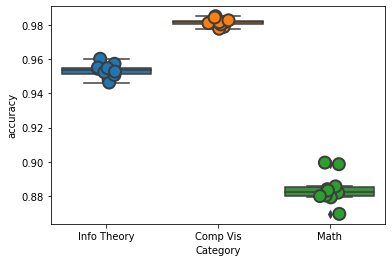

In [54]:
# Training: We use 3 different models and 5 fold cross validation to see which one is better

cv_df = pd.DataFrame(index = range(10))
entries = []


accuracies = cross_val_score(LogisticRegression(max_iter = 5000), TFIDF_feat_matrix, train_labels_infotheory, scoring='accuracy', cv = 10)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('Info Theory', fold_idx, accuracy))
    
accuracies = cross_val_score(LogisticRegression(max_iter = 5000), TFIDF_feat_matrix, train_labels_compvis, scoring='accuracy', cv = 10)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('Comp Vis', fold_idx, accuracy))

accuracies = cross_val_score(LogisticRegression(max_iter = 5000), TFIDF_feat_matrix, train_labels_math, scoring='accuracy', cv = 10)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('Math', fold_idx, accuracy))


cv_df = pd.DataFrame(entries, columns=['Category', 'fold_idx', 'accuracy'])
#cv_df


sns.boxplot(x='Category', y='accuracy', data=cv_df)
sns.stripplot(x='Category', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [55]:
train_label_classes = [train_labels_infotheory, train_labels_compvis, train_labels_math]
test_label_classes = [testing_labels_infotheory, testing_labels_compvis, testing_labels_math]
class_name = ['Info Theory', 'Comp Vis', 'Math']

for i in range(3):
    
    model = LogisticRegression(max_iter = 5000).fit(TFIDF_feat_matrix, train_label_classes[i])

    print(class_name[i])

    # prediction
    class_prediction = model.predict(testing_abstract_TFIDF)

    print(confusion_matrix(test_label_classes[i], class_prediction))
    
    

    f1score = f1_score(test_label_classes[i], class_prediction, average='macro')
    accuracy = accuracy_score(test_label_classes[i], class_prediction)
    matthews = matthews_corrcoef(test_label_classes[i], class_prediction)

    print('Accuracy: '+ str(accuracy))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))
    print('\n')


Info Theory
[[15855   207]
 [  787  2829]]
Accuracy: 0.949486736456957
Macro F1 score:0.9100887105742221
MCC:0.8249949697483571


Comp Vis
[[17453    73]
 [  701  1451]]
Accuracy: 0.9606667344242301
Macro F1 score:0.8838761119270802
MCC:0.7823801892002379


Math
[[12920   828]
 [ 1605  4325]]
Accuracy: 0.8763593861164752
Macro F1 score:0.8472103842308634
MCC:0.6983288468634726




In [56]:
TFIDF_vec = TfidfVectorizer(analyzer = 'word',
                            input = 'content',
                            
                            #
                            #token_pattern = r'[a-zA-Z]{1,}',
                            min_df = 2,
                            max_df = 0.5,
                            ngram_range = (1,2),
                            tokenizer = LemmaTokenizerSpacy())

In [57]:
#X Training
TFIDF_feat_matrix = TFIDF_vec.fit_transform(training_abstract_list)

#Y Training
train_labels_infotheory = np.asarray(training_infotheory_list)
train_labels_compvis = np.asarray(training_compvis_list)
train_labels_math = np.asarray(training_math_list)

#X Testing
testing_abstract_TFIDF = TFIDF_vec.transform(testing_abstract_list)

#Y Testing
testing_labels_infotheory = np.asarray(testing_infotheory_list)
testing_labels_compvis = np.asarray(testing_compvis_list)
testing_labels_math = np.asarray(testing_math_list)

### Cross Validation

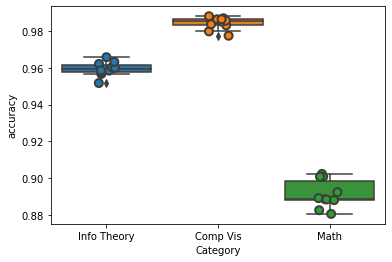

In [58]:
# Training: We use 3 different models and 5 fold cross validation to see which one is better

cv_df = pd.DataFrame(index=range(10))
entries = []

accuracies = cross_val_score(LinearSVC(max_iter = 5000), TFIDF_feat_matrix, train_labels_infotheory, scoring='accuracy', cv= 10)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('Info Theory', fold_idx, accuracy))

accuracies = cross_val_score(LinearSVC(max_iter = 5000), TFIDF_feat_matrix, train_labels_compvis, scoring='accuracy', cv=10)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('Comp Vis', fold_idx, accuracy))

    
accuracies = cross_val_score(LinearSVC(max_iter = 5000), TFIDF_feat_matrix, train_labels_math, scoring='accuracy', cv=10)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('Math', fold_idx, accuracy))


    
cv_df = pd.DataFrame(entries, columns=['Category', 'fold_idx', 'accuracy'])
#cv_df


sns.boxplot(x='Category', y='accuracy', data=cv_df)
sns.stripplot(x='Category', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


### ML Models

In [59]:
train_label_classes = [train_labels_infotheory, train_labels_compvis, train_labels_math]
test_label_classes = [testing_labels_infotheory, testing_labels_compvis, testing_labels_math]
class_name = ['Info Theory', 'Comp Vis', 'Math']

# models = [LogisticRegression(max_iter = 5000)]
# models = [BernoulliNB()]
# models = [LinearSVC(max_iter = 5000)]


for i in range(3):

    model = LinearSVC(max_iter = 5000, C = 0.5).fit(TFIDF_feat_matrix, train_label_classes[i])
    print(class_name[i])

    # prediction
    class_prediction = model.predict(testing_abstract_TFIDF)

    print(confusion_matrix(test_label_classes[i], class_prediction))

    f1score = f1_score(test_label_classes[i], class_prediction, average='macro')
    accuracy = accuracy_score(test_label_classes[i], class_prediction)
    matthews = matthews_corrcoef(test_label_classes[i], class_prediction)

    print('Accuracy: '+ str(accuracy))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))
    print('\n')

Info Theory
[[15828   234]
 [  640  2976]]
Accuracy: 0.9555849171663787
Macro F1 score:0.9225463227209683
MCC:0.8474011173716384


Comp Vis
[[17440    86]
 [  490  1662]]
Accuracy: 0.9707287325947759
Macro F1 score:0.9180311024715357
MCC:0.8418258339058456


Math
[[12862   886]
 [ 1412  4518]]
Accuracy: 0.8832198394145746
Macro F1 score:0.8576201131237012
MCC:0.717010126492889




#### Results for Method - Logistic Regression

Full confusion matrix for method on InfoTheory:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   15855     |     207     |
| **Actual = 1**  |   787       |     2829    |

Full confusion matrix for method on CompVis:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   17453     |      73     |
| **Actual = 1**  |   701       |      1451   |

Full confusion matrix for method on Math:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   12920     |     828     |
| **Actual = 1**  |   1605      |     4325    |


#### Results for Method - Linear SVC

Full confusion matrix for method on InfoTheory:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   15828     |     234     |
| **Actual = 1**  |   640       |     2976    |

Full confusion matrix for method on CompVis:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   17440     |      86     |
| **Actual = 1**  |   490       |      1662   |

Full confusion matrix for method on Math:

|                 |   Pred = 0  |   Pred = 1  |
| --------------  | ----------- | ----------- |
| **Actual = 0**  |   12862     |     886     |
| **Actual = 1**  |   1412      |     4518    |


## Part 2: Topic Modelling

General comments and any shared processing here.


In [368]:
# Reading the CSV file and copying the body content of all the news articles into a list
# monash_text is the data frame containing the entire csv file
# docs contains the article bodies as a list

monash_text = pd.read_csv('Monash_crawled.csv')

docs = monash_text['body'].tolist()

print('Total Number of Documents: %d' % len(docs))

Total Number of Documents: 366


### LDA 1st Run

#### Text Pre Processing

#### RegEx Tokenizer and WordNet Lemmatizer (NLTK)

In [369]:
# Tokenize the documents
# Split the documents into tokens using the RegEx pattern '\w+'
# Initialize a tokenizer object
# Use a for loop to iterate over the docs list and convert all the strings to lower case and then apply the tokenizer object we defined

tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Removing numbers that are by themselves. That is numbers with other characters included in them are ignored
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
# This operation will pick out characters like 'a' which occurs a lot in the english language and also some stray characters that provide no value
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Finally, Lemmatize the documents using the WordNet lemmatizer object.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

#### Bigrams

In [370]:
# We can generate bigrams using the Phrases method
bigram = Phrases(docs, min_count = 10)

# The phrases method returns all the bigrams founds in each document along with all the tokens
# Since we're only interested in the bigrams we look for an '_' in each word and append those elements into our existing list of tokens
for i in range(len(docs)):
    for token in bigram[docs[i]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[i].append(token)

In [371]:
# long_string = ''

# for doc in docs:
    
#     for item in doc:
        
#         long_string = long_string + ',' + item
    

In [372]:
# # Import the wordcloud library
# from wordcloud import WordCloud, STOPWORDS
# # Join the different processed titles together.
# stopwords = set(STOPWORDS)
# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", stopwords=stopwords, max_font_size=60, max_words=50, contour_width=3)
# # Generate a word cloud
# wordcloud.generate(long_string)
# # Visualize the word cloud
# wordcloud.to_image()

#### Removing Rare Tokens

In [373]:
# Remove rare and common tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur in less than 50 documents, or in more than 50% of the documents.
dictionary.filter_extremes(no_below = 20, no_above = 0.6)

#### Map of all words to a unique ID

In [374]:
# Bag-of-words representation of the documents
# The method doc2bow assigns a unique ID (natural numbers starting from 0)
# The corpus is a 2D list. Each element in the list is a list of tuples of the form (toked id, token frequency)

corpus = [dictionary.doc2bow(doc) for doc in docs]

In [375]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1480
Number of documents: 366


#### Saving the models

In [376]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary_1.gensim')

### Trainining the first model

#### Adjusting the parameters

In [377]:
# We have 366 articles. 10 Topics would be suitable
# Chunksize size is the number of documents that will be processed at once

# passes are the number of times we train the model on the entire corpus and
# iterations are how often we repeat a particular loop over each document

NUM_TOPICS = 10
chunksize = 2000
passes = 30
iterations = 500
eval_every = None


#### Making a word index

In [378]:
# This code makes an index to word dictionary
# The key is the unique ID generated above using doc2bow
# The value is the corresponding word or token

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

#### Model Training

In [379]:
model = LdaModel(
    corpus = corpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = 'auto',
    eta = 'auto',
    iterations = iterations,
    num_topics = NUM_TOPICS,
    passes = passes,
    eval_every = eval_every
)

#### Saving the model

In [380]:
outputfile = f'Assg_topics_{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

Saving model in Assg_topics_10.gensim



In [381]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)


Average topic coherence: -0.8448.


In [382]:

# Print the Keyword in the 10 topics

pprint(model.print_topics())

[(0,
  '0.031*"february" + 0.023*"ship" + 0.019*"cruise" + 0.014*"case" + '
  '0.013*"princess" + 0.013*"cruise_ship" + 0.012*"japan" + 0.012*"passenger" '
  '+ 0.011*"diamond_princess" + 0.011*"diamond"'),
 (1,
  '0.032*"february" + 0.023*"flight" + 0.016*"wuhan" + 0.015*"island" + '
  '0.012*"christmas" + 0.011*"passenger" + 0.009*"qantas" + 0.009*"pictured" + '
  '0.008*"quarantine" + 0.007*"evacuee"'),
 (2,
  '0.010*"area" + 0.009*"fire" + 0.007*"study" + 0.007*"say" + 0.006*"you" + '
  '0.006*"could" + 0.006*"climate" + 0.006*"research" + 0.005*"smoke" + '
  '0.005*"time"'),
 (3,
  '0.014*"minister" + 0.013*"thursday" + 0.012*"ship" + 0.011*"virus" + '
  '0.011*"morrison" + 0.011*"on_thursday" + 0.009*"mr" + 0.009*"pandemic" + '
  '0.009*"february" + 0.008*"government"'),
 (4,
  '0.046*"student" + 0.020*"ban" + 0.020*"february" + 0.019*"travel" + '
  '0.019*"china" + 0.016*"chinese" + 0.012*"travel_ban" + 0.011*"country" + '
  '0.009*"chinese_student" + 0.009*"week"'),
 (5,
  '0.0

In [383]:
#!pip3 install pyLDAvis

lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

### LDA 2nd Run

In [589]:
monash_text.head()

,uri,url,date,title,body
0,1395271488,http://www.theguardian.com/environment/2020/ja...,2020-01-01,Canberra experiences worst air quality on reco...,Canberra\n has experienced its worst air qual...
1,1396563053,https://weather.com/news/news/2020-01-02-thous...,2020-01-02,Thousands Clog Roads Fleeing Australian Bushfi...,As\n dawn broke over a blackened Australi...
2,1397549175,https://www.businessinsider.com/baby-milestone...,2020-01-03,Key milestones your baby can reach in the firs...,Your baby's brain and body grow a lot during ...
3,1397689515,https://www.dailymail.co.uk/health/article-784...,2020-01-03,"Air pollution can break your BONES, study sugg...",Living in polluted cities may make your bones...
4,1397806413,https://www.independent.co.uk/life-style/gadge...,2020-01-03,'World's most efficient battery' can power a s...,Researchers have developed a new battery they...


### Deleing the new line characters and stop words

In [590]:
# There are 2 text columns, Title and Body
# Usually the Title's words are a sub set of the body and therefore it is okay to ignore it
# We take the text column into a list

monash_text_list = monash_text['body'].tolist()

In [591]:
# Numpy arrays are faster to iterate through
# So we convert the list of text bodies into a Numpy array
# In this cell we delete all punctuations and stop words in the text

training_abstract_array = np.asarray(monash_text_list)

stop_words_en = set(stopwords.words('english'))
stop_words_en = Counter(stop_words_en)

for i, txt in enumerate(training_abstract_array):
    
    
# Substituting with an empty string every character that is not an alphabet or white space.
# This gets rid of all the punctuations and unnecessary characters
    temp = re.sub(r'[^a-zA-Z ]', '', str(txt))
    
# Splitting each document into individual words and joining them back while removing words that are present in the stop word list    
    training_abstract_array[i] = ' '.join([word for word in temp.lower().split() if word not in stop_words_en])
    
# Converting the array back into a list
monash_text_list = training_abstract_array.tolist()

### Spacy Lemmatizer

In [592]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [593]:
# This cell loops through the text body list and tokenizes the text and returns a list of tokens

for i, txt in enumerate(monash_text_list):
    
    trydoc = nlp(str(txt))
    
    monash_text_list[i] = [token.lemma_ for token in trydoc]

#### Bigrams

In [594]:
# We can generate bigrams using the Phrases method

bigram_generator = Phrases(monash_text_list, min_count = 40)

# The phrases method returns all the bigrams founds in each document along with all the tokens
# Since we're only interested in the bigrams we look for an '_' in each word and append those elements into our existing list of tokens

for i in range(len(monash_text_list)):
    for token in bigram[monash_text_list[i]]:
        if '_' in token:
            # Token is a bigram, add to document.
            monash_text_list[i].append(token)

#### New model - Remove rare tokens

In [595]:
# Removing rare and common tokens
# Creating a dictionary representation of the documents
monash_dictionary = Dictionary(monash_text_list)

# Filtering out words that occur in less than 20 documents or more than 70% of the documents.
monash_dictionary.filter_extremes(no_below = 20, no_above = 0.7)

#### Map of all words to a unique ID

In [596]:
# Bag-of-words representation of the documents
# The method doc2bow assigns a unique ID (natural numbers starting from 0)
# The corpus is a 2D list. Each element in the list is a list of tuples of the form (toked id, token frequency)

monash_corpus = [monash_dictionary.doc2bow(each) for each in monash_text_list]

In [597]:
print('Number of unique tokens: %d' % len(monash_dictionary))
print('Number of documents: %d' % len(monash_corpus))

Number of unique tokens: 1214
Number of documents: 366


#### Saving the models

In [598]:
pickle.dump(monash_corpus, open('monash_corpus.pkl', 'wb'))
monash_dictionary.save('monash_dictionary.gensim')

### Training the model

#### Tuning Model Parameters

In [599]:
# For this run we're trying only 6 topics
# Chunksize size is the number of documents that will be processed at once
# passes are the number of times we train the model on the entire corpus and
# iterations are how often we repeat a particular loop over each document

MONASH_TOPICS = 6
monash_chunksize = 2000
monash_passes = 30
monash_iterations = 1000
eval_every = None

#### Make a word index

In [600]:
# This code makes an index to word dictionary
# The key is the unique ID generated above using doc2bow
# The value is the corresponding word or token

temp = monash_dictionary[0]

monash_id2word = monash_dictionary.id2token

#### New Model

In [601]:
monash_model = LdaModel(
    corpus = monash_corpus,
    id2word = monash_id2word,
    chunksize = monash_chunksize,
    alpha = 'auto',
    eta = 'auto',
    iterations = monash_iterations,
    num_topics = MONASH_TOPICS,
    passes = monash_passes,
    eval_every = eval_every
)

In [602]:
outputfile = f'Monash_Text_{NUM_TOPICS}_Topics.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

Saving model in Monash_Text_10_Topics.gensim



In [603]:
monash_top_topics = monash_model.top_topics(monash_corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
monash_avg_topic_coherence = sum([t[1] for t in monash_top_topics]) / MONASH_TOPICS
print('Average topic coherence: %.4f.' % monash_avg_topic_coherence)

# from pprint import pprint
# pprint(top_topics)

Average topic coherence: -0.7130.


### Topics Generated

In [604]:
# Print the Keywords for the topics identified
pprint(monash_model.print_topics())

[(0,
  '0.021*"virus" + 0.017*"coronavirus" + 0.016*"china" + 0.015*"case" + '
  '0.012*"wuhan" + 0.012*"health" + 0.009*"test" + 0.008*"symptom" + '
  '0.008*"confirm" + 0.008*"spread"'),
 (1,
  '0.026*"february" + 0.023*"january" + 0.016*"mask" + 0.014*"coronavirus" + '
  '0.011*"face" + 0.009*"south" + 0.008*"not" + 0.008*"tell" + 0.007*"one" + '
  '0.007*"chinese"'),
 (2,
  '0.018*"area" + 0.014*"use" + 0.013*"woman" + 0.011*"study" + '
  '0.011*"university" + 0.010*"fire" + 0.009*"climate" + 0.008*"patient" + '
  '0.008*"year" + 0.008*"change"'),
 (3,
  '0.010*"could" + 0.009*"make" + 0.008*"work" + 0.008*"time" + 0.008*"get" + '
  '0.008*"one" + 0.008*"smoke" + 0.007*"air" + 0.007*"go" + 0.007*"like"'),
 (4,
  '0.020*"student" + 0.015*"coronavirus" + 0.015*"university" + 0.012*"would" '
  '+ 0.011*"china" + 0.010*"ban" + 0.010*"australian" + 0.010*"school" + '
  '0.010*"per" + 0.010*"cent"'),
 (5,
  '0.036*"february" + 0.028*"january" + 0.015*"ship" + 0.014*"coronavirus" + '
  '0

### Interactive Visualization of the Topics

In [605]:
monash_lda_display = pyLDAvis.gensim.prepare(monash_model, monash_corpus, monash_dictionary, sort_topics = True)
pyLDAvis.display(monash_lda_display)